# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [1]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

## Generating the data

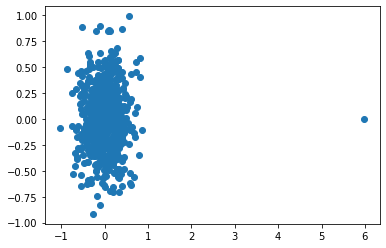

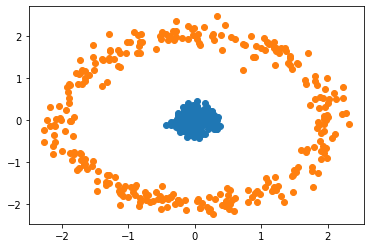

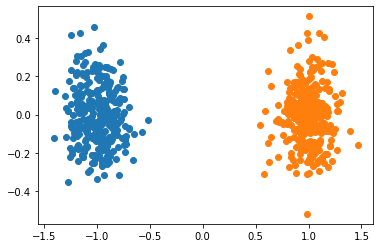

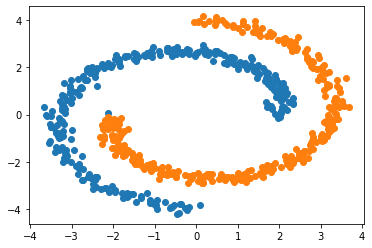

In [2]:
# Example

for fn in [worst_case_blob, point_and_circle, blobs, two_moons]:
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
# worst_case_blob?

## Building similarity graph

In [3]:
def dist(x_i, x_j, var=1.0):
    return np.exp(-np.sum((x_i - x_j)**2, axis=-1)/(2 * var))

In [4]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = dist(X[:, None, :], X)

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W = similarities * (similarities >= eps)

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        for node in range(n):
            for close_node in np.argsort(-similarities[node])[:k+1]:
                W[node, close_node] = similarities[node, close_node]
                W[close_node, node] = similarities[node, close_node]  # Use Or method to have a symmetric W

    return W

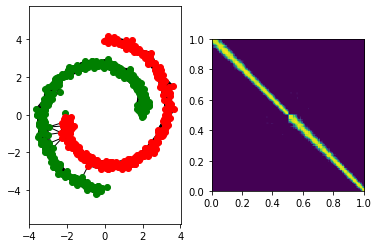

In [5]:
# Example

W = build_similarity_graph(X, eps=0.75)
# W[0, 599] = 1    # for example, to visualize below
# W[599, 0] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [6]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    W += np.eye(W.shape[0])
    D = np.sum(W, axis=0) # Shape n
    L = np.diag(D) - W
    if laplacian_normalization == "unn":
        return L
    elif laplacian_normalization == "sym":
        D_inv_sqrt = np.diag(1 / np.sqrt(D))
        return D_inv_sqrt @ L @ D_inv_sqrt
    elif laplacian_normalization == "rw":
        D_inv = np.diag(1 / D)
        return D_inv @ L

    raise ValueError

## Clustering

In [7]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    E, U = np.linalg.eigh(L)  # Use the fact that L is real symmetric.

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    
    if chosen_eig_indices:
        U = U[:, chosen_eig_indices]
    else:
        # choose the k first eigenvectors (as often done in the literature.)
        U = U[:, :num_classes]

    Y = KMeans(n_clusters=num_classes).fit_predict(U)
    return Y

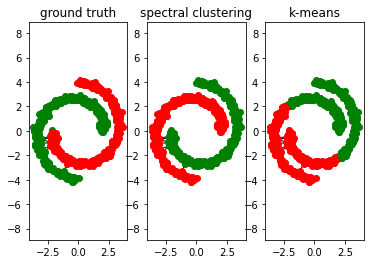

In [8]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [9]:
def parameter_sensitivity(parameter, candidates):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None

    """
    Choose candidate parameters
    """
    parameter_performance = []

    for value in candidates:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))

        W = build_similarity_graph(X, **{parameter: value})
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(candidates, parameter_performance)
    plt.title(f'{parameter} sensitivity')
    plt.show()

## Image segmentation

In [10]:
def image_segmentation(input_img='four_elements.bmp', n=4):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1.0
    k = 55
    laplacian_normalization = 'unn'
    chosen_eig_indices = None
    num_classes = n

    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

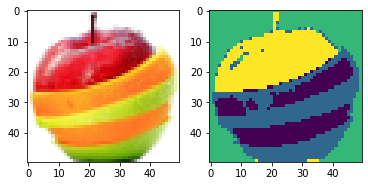

In [12]:
image_segmentation("fruit_salad.bmp", n=4)

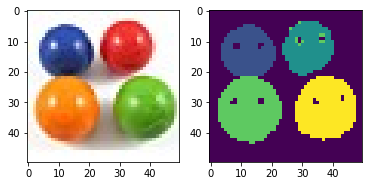

In [13]:
image_segmentation(n=5)

# Questions

### Q1: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph. 

With k connected components, the multiplicity of the 0 eigenvalue is k and any eigenvector associated is constant over these components. Therefore if we use these eigenvectors, we will more likely cluster with kmeans the connected components with themselves. (Which is what we often wish to do.)

Nonetheless it could maybe be harder to go beyond this trivial clustering, and typically when we seek less clusters than connected components, the algorithm will tend to return this trivial clustering. It's advised to use connected graph as it won't lower the clustering performances, but the main drawback is that we will probably keep much more edges and could lost the sparse property.

Proportion of edges: 0.05173333333333333


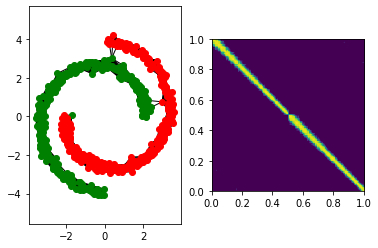

In [364]:
X, Y = two_moons(num_samples=600)
# plot_clusters(X, Y, fignum=str(fn))
W = build_similarity_graph(X, eps=0.75)
print("Proportion of edges:", np.sum(W != 0) / W.size)
plot_graph_matrix(X, Y, W)

Proportion of edges: 0.029355555555555555


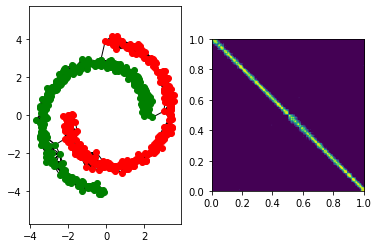

In [365]:
X, Y = two_moons(num_samples=600)
# plot_clusters(X, Y, fignum=str(fn))
W = build_similarity_graph(X, k=15)
print("Proportion of edges:", np.sum(W != 0) / W.size)
plot_graph_matrix(X, Y, W)

Proportion of edges: 0.29806666666666665


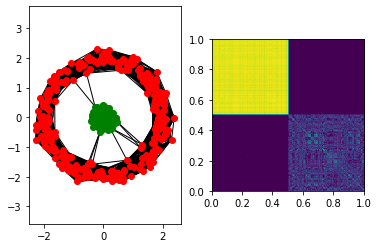

In [366]:
X, Y = point_and_circle(num_samples=600)
# plot_clusters(X, Y, fignum=str(fn))
W = build_similarity_graph(X, eps=0.5)
print("Proportion of edges:", np.sum(W != 0) / W.size)
plot_graph_matrix(X, Y, W)

Proportion of edges: 0.10798333333333333


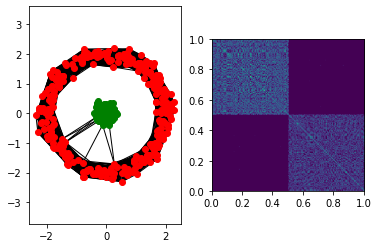

In [367]:
X, Y = point_and_circle(num_samples=600)
# plot_clusters(X, Y, fignum=str(fn))
W = build_similarity_graph(X, k=55)
print("Proportion of edges:", np.sum(W != 0) / W.size)
plot_graph_matrix(X, Y, W)

On these two examples here, we can see that trying to tune $\epsilon$ or k in order to have a connected graph leads to less sparse graph for $\epsilon$-graphs than for knn-graphs.

It's more difficult to build a connected $\epsilon$-graph. This problem is even more understandable if we had data of different scales, where we have several different average distance between points. An $\epsilon$-graph would not succeed to build a sparse connected graph.

### Q2: The function `min_span_tree` can be used to choose the value of $\epsilon$ that keeps the graph connected. Using the `worst_case_blob`, can you tell when it is a bad idea to use this approach?

We can use min span tree to find an spaning tree with maximum similarities. Then by taking its minimum edge, we would find a suitable value for $\epsilon$!

Proportion of edges: 0.04688888888888889


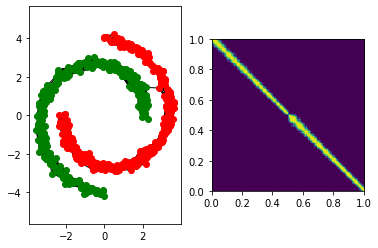

In [363]:
X, Y = two_moons(num_samples=600)
similarities = dist(X[:, None, :], X)
mst = min_span_tree(-similarities)  # Find the max-span-tree
eps = np.min(np.where(mst, similarities, np.inf))

W = build_similarity_graph(X, eps=eps)
print("Proportion of edges:", np.sum(W != 0)/W.size)
plot_graph_matrix(X, Y, W)

Proportion of edges: 0.9966777777777778


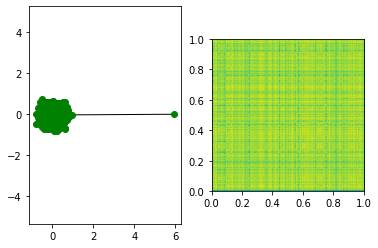

In [368]:
X, Y = worst_case_blob(num_samples=600)
similarities = dist(X[:, None, :], X)
mst = min_span_tree(-similarities)  # Find the max-span-tree
eps = np.min(np.where(mst, similarities, np.inf))

W = build_similarity_graph(X, eps=eps)
print("Proportion of edges:", np.sum(W != 0)/W.size)
plot_graph_matrix(X, Y, W)

With the worst case blob example, the only way to have a connected $\epsilon$-graph is to have a almost fully connected graph! (One can also see that it is also true with a knn-graph)

The min-span-tree is a good idea to get a connected graph, but it's not useful when there are really several (and well separated) components, as we will fallback on the fully connected graph (and we could have used it directly)

### Q3: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

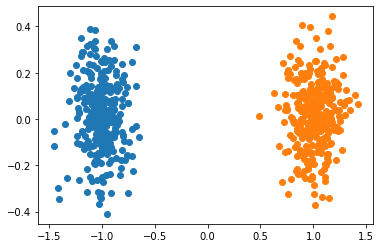

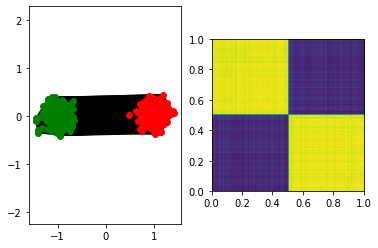

In [373]:
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)
W = build_similarity_graph(X, eps=0) # Keep the fully connected graph 
# (Could have used min-span-tree to filter half of edges)
plot_graph_matrix(X, Y, W)

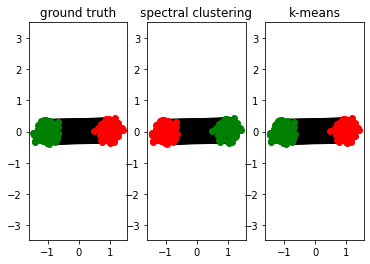

In [374]:
num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

As we have here a connected graph, the kernel of the laplacian is $\text{vect}(1_n)$: 0 is an eigenvalue of the laplacian with multiplicity 1, and the associated eigenvectors are constant and thus of no use for the clustering.

The idea is to take the following eigenvectors for the clustering, in this particular case, when looking for 2 clusters, we show with the Rayleigh-Ritz theorem, that the second eigenvector is an approximate minimizer of the ratio graph cut. (and same for $L_{rw}$ with NCut)

I have therefore used the second eigenvector. In order to go from the vector to labels, there are two ideas, we can use a thresholding at 0, but it's often more reliable to use kmeans directly on the vector.

Moreover if we were looking for more than two clusters (k), the Rayleigh-Ritz theorem can also be used to justify the use of the $k$ first eigenvectors. And we use a kmeans to find the cluster of each point. (I will therefore also use kmeans for $k = 2$)

Our spectral clustering and kmeans have similar results here. (This is a case where kmeans is typically good.)

### Q4: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

As explained before, the Rayleigh-Ritz theorem can also be used to justify the use of the $k$ first eigenvectors. This is the most simple solution, and we can perform kmeans directly. It can be done only if the number of clusters is known.

We could also try another solution, based on the smoothness of the eigenvectors (which is its eigenvalue). The idea would be to guess the number of clusters from the eigenvalues: Find the bend/gap in the spectrum of the laplacian. And thus select the corresponding eigenvectors.

Here I decided to use the simplest solution, and considered that we know the number of clusters k and use the k first eigenvectors. We can interpret them as the k smoothest eigenvectors (which make sense). Note that we can drop the first eigenvector in a connected graph (it is constant). But here I decided not to make such an assumption.

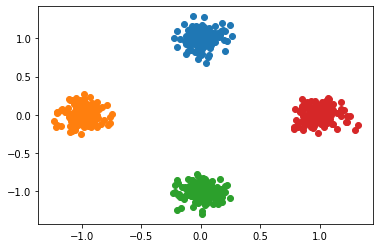

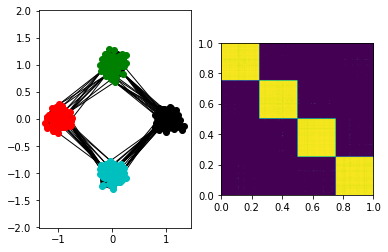

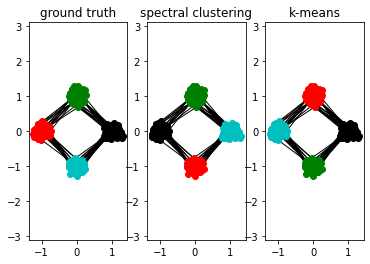

In [421]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.1)
plot_clusters(X, Y)
similarities = dist(X[:, None, :], X)
mst = min_span_tree(-similarities)  # Find the max-span-tree
eps = np.min(np.where(mst, similarities, np.inf))
W = build_similarity_graph(X, eps=eps-0.05)
plot_graph_matrix(X, Y, W)

num_classes = 4
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

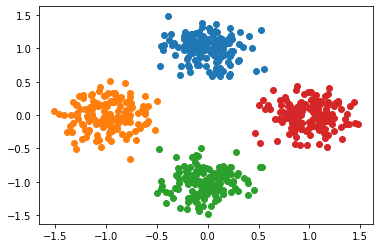

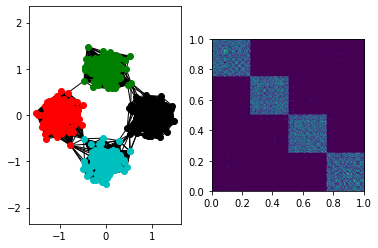

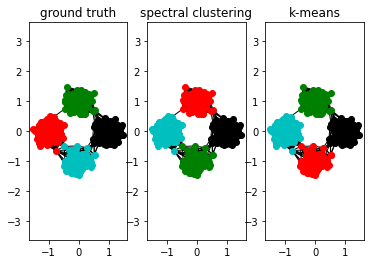

In [441]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.2)
plot_clusters(X, Y)
W = build_similarity_graph(X, k=35)
plot_graph_matrix(X, Y, W)

num_classes = 4
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

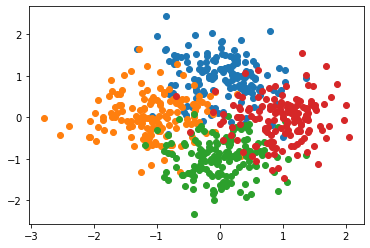

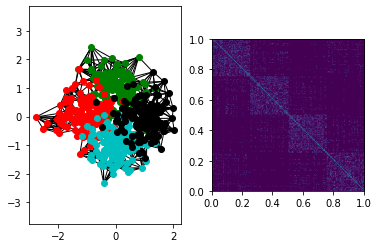

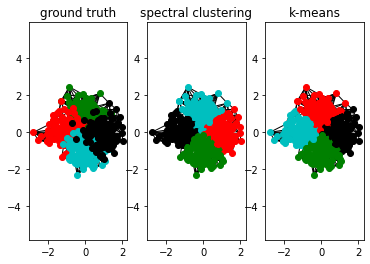

In [444]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.5)
plot_clusters(X, Y)
W = build_similarity_graph(X, k=10)
plot_graph_matrix(X, Y, W)

num_classes = 4
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

It seems to work quite well. Nonetheless with an epsilon graph and with high variance, the algorithm seems to merge some clusters, a way to solve it, is to ask more clusters or to use knn-graphs. Here the knn simplification seems to outperforms the epsilon one.

### Q5: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

As said in question 2, I decided to use Kmeans. Thresholding is simpler but sometimes too simple, and it cannot be applied that simply when $k!=2$ as we use more than a single eigenvector.

### Q6: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

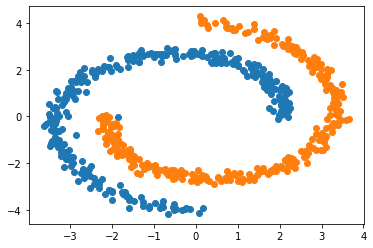

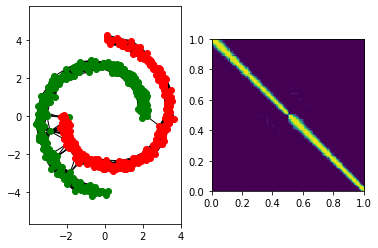

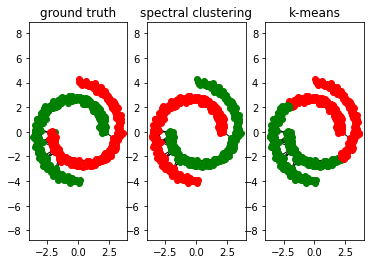

In [465]:
X, Y = two_moons(600)
plot_clusters(X, Y)
W = build_similarity_graph(X, eps=0.70)
plot_graph_matrix(X, Y, W)

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

Here spectral clustering outperforms kmeans, it's totally expected as kmeans cannot handle these kind of data, it's only based on euclidian distance and can only forms "globish" clusters.

A second remark is that here epsilon-graphs outperforms knn-graphs, with a knn-connected-graph the clustering is not always perfect (less stable than with epsilon graphs). The intuition we can have is that with this data, an epsilon graph has much more edges in the each moon part, and thus it's harder to cut inside the moon. (Whereas the knn-graphs has less edges, and the edges between the two moons are not enough easier to cut than those inside one moon).

(Of course if we use small enough k for knn, we would have 2 connected components and the algorithm would not have a problem to separate the data. Here with epsilon=0.7 and k=20 we have one connected component and around the same number of edges between components, but the epsilon graphs clustering is much more stable as explained)

### Q7: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

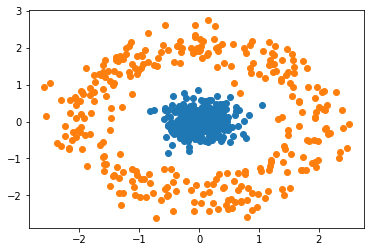

In [485]:
X, Y = point_and_circle(600, sigma=0.3)
plot_clusters(X, Y)

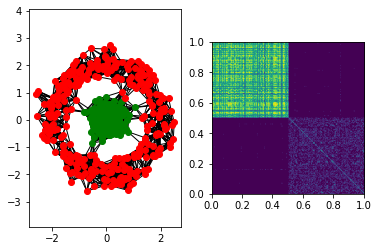

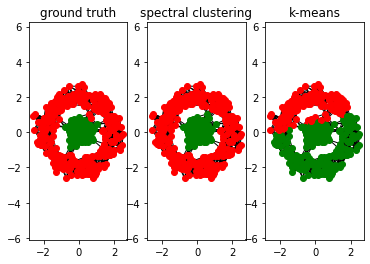

In [491]:
W = build_similarity_graph(X, eps=0.8)
plot_graph_matrix(X, Y, W)

num_classes = 2
L = build_laplacian(W, laplacian_normalization="unn")
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

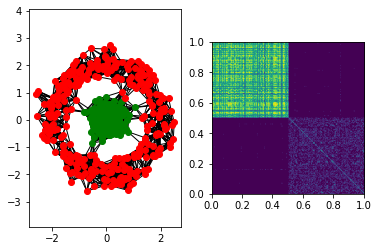

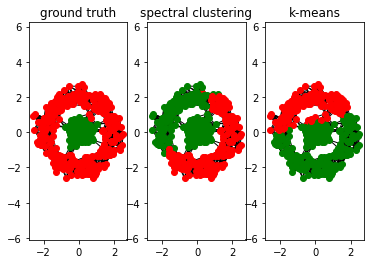

In [492]:
W = build_similarity_graph(X, eps=0.8)
plot_graph_matrix(X, Y, W)

num_classes = 2
L = build_laplacian(W, laplacian_normalization="rw")
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

In [504]:
print("Vertices repartition:", Y.sum(), (1-Y).sum())
print("Edges repartition:", W[Y==1].sum(), W[Y==0].sum())

Vertices repartition: 300 300
Edges repartition: 6930.227975154734 59045.302304061996


The random walk regularized laplacian seems to have trouble to find the good clusters. The explanation is that with $L_{rw}$ we are solving a NCut problem where we try to find a cut balanced in volume (Some of edges) whereas with $L$ we solve the RatioCut problem where we try to find a cut balanced in number of vertices.

Here there are around the same number of vertices in each true cluster. But the volume is quite different, the point cluster has a much higher volume than the circle one as it contains much closer points (and thus each wij inside the point is quite high). The NCut problem is not the one that we should try to solve! (Which is why it fails to do a correct clustering)

### Q8: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

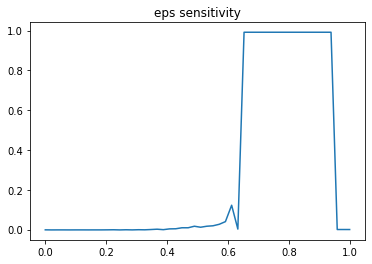

In [520]:
parameter_sensitivity("eps", np.linspace(0, 1, 50))

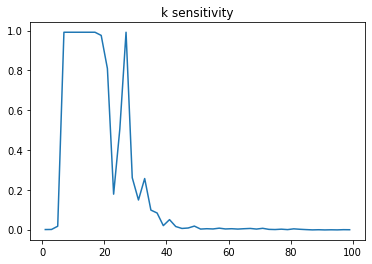

In [519]:
parameter_sensitivity("k", range(1, 100, 2))

Both curves show the stability of the algorithm when the graph is in two connected components. (Low k, and high epsilon). There still some values for epsilon (and probably k) where the graph is connected and the clustering is stable. But it shows that when we keep too much edges, the clustering performs poorly: the moon are too close and the minimal cut does not separate them (as shown below)

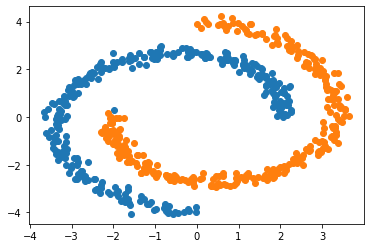

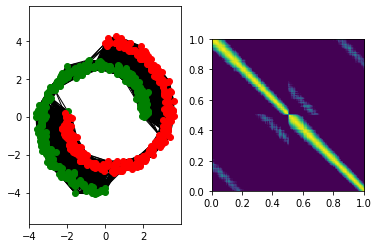

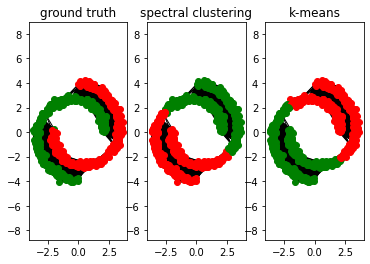

In [521]:
X, Y = two_moons(600)
plot_clusters(X, Y)
W = build_similarity_graph(X, eps=0.40)
plot_graph_matrix(X, Y, W)

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q9: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

We could use classical evaluation methods, like Silhouette Coefficient or Inertia, but we have to keep in mind that that those kind of method based on euclidian distance will reward convex clustering, which is not what we are doing here!

A better indication is probably the value of the cut that we have (Some of all the extra clusters edges). In order to avoid to do trivial clustering and increase scores of unbalanced cuts, we should also used balanced cuts.

As shown in 7, having an a priori on the data we wan't to cluster is very useful to choose which balanced cut is appropriate.

(One could also think about the modularity as in the Louvain algortihm)

### Q10: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

We could use very sparse coding by adding location constraint on clusters. Here we are drawing an edge between the k nearest pixels in the color space, we could also draw an edge only when two pixels are separated by less than d pixels. (With d a parameter to tune). This would increase a lot the matrixes sparsity and thus the memory and computational cost.

We could also downsample the images, and then upsample the resulting clustering to fit the initial size.

Another idea less naive than downsampling is to group pixels into superpixels when they share almost the same color.